In [1]:
#  import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pyarrow 

# define variables
file_version = ".1"
immo_vis_dir = "../../data/immo_vis/"
parquet_extension = ".parquet"
metropole_appartement_file = "ventes-metropole-appartement" + file_version  + parquet_extension
metropole_maison_file = "ventes-metropole-maison" +  file_version + parquet_extension
metropole_appartement_file_cleaned = metropole_appartement_file + "_step1_clean_" + parquet_extension

dpe_ranking     = ['0','A','B','C','D','E','F','F/G','G','NS','Unknown']
dpe_ranking_num = [0,1,2,3,4,5,6,7,7,0,0]

#  Set plot options
LargePlotActive = False
MediumPlotActive = False
SmallPlotActive = False
HeatMapDisplay = False

# chauffage système
chauffage_sys =["chauf_sys_climatisation","chauf_sys_radiateur","chauf_sys_pompe-chaleur","chauf_sys_chaudiere","chauf_sys_convecteur","chauf_sys_sol","chauf_sys_poele-bois"]
chauffage_mode =["chauffage_mode_individuel","chauffage_mode_collectif","chauffage_mode_central"]
chauffage_energie =["chauf_fioul","chauf_elec","chauf_gaz","chauf_bois"]
chauffage_systems = chauffage_sys + chauffage_mode + chauffage_energie

# expositions
expositions =['expo_has_nord', 'expo_has_sud', 'expo_has_est', 'expo_has_ouest']


# # functions

In [2]:
# functions  

def print_numerical_isna(df) :
    columns = df.select_dtypes(include='number').columns.tolist()
    print (df[columns].isna().sum())

def print_categorial_isna(df) :
    columns = df.select_dtypes(include='category').columns.tolist()
    print (df[columns].isna().sum())     

def load_appartement_file () :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file
    return pd.read_parquet(final_path.as_posix())

def save_appartement_file (df) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file_cleaned
    final_path.as_posix
    df.to_parquet(path=final_path.as_posix(),index=True)

def get_numerical_column_names (df) :
    return [ column for column  in df.columns if df[column].dtype not in ["object","category"]]


In [3]:
# chauffage système
def display_heatmap(df, data_selection,target="prix_m2_vente",size=8,annotation=True) : 
    plt.figure(figsize=[size,size])

    data_selection.append(target)
    param = {
        'vmax': 1, 
        'vmin': -1, 
        'cmap': 'coolwarm', 
        'annot': annotation,
        'square': True,           # Cellules carrées
        'fmt': '.2f',            # Format des nombres (3 décimales)
        'cbar_kws': {'label': 'Corrélation'}  # Label de la colorbar
    }
    data = df.loc[:,data_selection].corr()
    display(data[target])
    sns.heatmap(data=data,**param)

# # decode file and display infos

In [4]:
# import appartement file

start_path = Path(immo_vis_dir)
final_path = start_path / metropole_appartement_file
df = load_appartement_file()
nb_rows= df.shape[0]
nb_cols= df.shape[1]

In [5]:
#  print main infos on appartmeent file


print ( f" {metropole_appartement_file} rows {nb_rows} columns {nb_cols}")
print (df.shape)
print (df.columns)
print (df.info())
print (df.describe())



 ventes-metropole-appartement.1.parquet rows 2438201 columns 59
(2438201, 59)
Index(['idannonce', 'type_annonceur', 'typedebien', 'typedetransaction',
       'etage', 'surface', 'surface_terrain', 'nb_pieces', 'prix_bien',
       'prix_maison', 'prix_terrain', 'mensualiteFinance', 'balcon', 'eau',
       'bain', 'dpeL', 'dpeC', 'mapCoordonneesLatitude',
       'mapCoordonneesLongitude', 'annonce_exclusive', 'nb_etages', 'parking',
       'places_parking', 'cave', 'exposition', 'ges_class',
       'annee_construction', 'nb_toilettes', 'nb_terraces', 'videophone',
       'porte_digicode', 'surface_balcon', 'ascenseur', 'nb_logements_copro',
       'charges_copro', 'chauffage_energie', 'chauffage_systeme',
       'chauffage_mode', 'categorie_annonceur', 'logement_neuf', 'duree_int',
       'typedebien_lite', 'date', 'INSEE_COM', 'IRIS', 'CODE_IRIS',
       'TYP_IRIS_x', 'TYP_IRIS_y', 'GRD_QUART', 'UU2010', 'REG', 'DEP',
       'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6',
      

/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [6]:
#  print columns modalities
for i in df.columns:
    print(f'modalities  {i} are : ',(df[i].nunique()))

modalities  idannonce are :  2438201
modalities  type_annonceur are :  2
modalities  typedebien are :  2
modalities  typedetransaction are :  3
modalities  etage are :  133
modalities  surface are :  623
modalities  surface_terrain are :  8591
modalities  nb_pieces are :  37
modalities  prix_bien are :  62733
modalities  prix_maison are :  0
modalities  prix_terrain are :  0
modalities  mensualiteFinance are :  3859
modalities  balcon are :  44
modalities  eau are :  37
modalities  bain are :  40
modalities  dpeL are :  19
modalities  dpeC are :  8202
modalities  mapCoordonneesLatitude are :  463889
modalities  mapCoordonneesLongitude are :  613143
modalities  annonce_exclusive are :  3
modalities  nb_etages are :  111
modalities  parking are :  2
modalities  places_parking are :  217
modalities  cave are :  2
modalities  exposition are :  523
modalities  ges_class are :  19
modalities  annee_construction are :  595
modalities  nb_toilettes are :  49
modalities  nb_terraces are :  91
m

In [7]:
#  print comlmns nan values
for i in df.columns:
    print(f' {i} nan values {df[i].isna().sum()}  {(100*df[i].isna().sum()/len(df)):.2f}%')

 idannonce nan values 0  0.00%
 type_annonceur nan values 0  0.00%
 typedebien nan values 0  0.00%
 typedetransaction nan values 0  0.00%
 etage nan values 0  0.00%
 surface nan values 0  0.00%
 surface_terrain nan values 2351341  96.44%
 nb_pieces nan values 0  0.00%
 prix_bien nan values 0  0.00%
 prix_maison nan values 2438201  100.00%
 prix_terrain nan values 2438201  100.00%
 mensualiteFinance nan values 0  0.00%
 balcon nan values 0  0.00%
 eau nan values 0  0.00%
 bain nan values 0  0.00%
 dpeL nan values 0  0.00%
 dpeC nan values 736665  30.21%
 mapCoordonneesLatitude nan values 0  0.00%
 mapCoordonneesLongitude nan values 0  0.00%
 annonce_exclusive nan values 0  0.00%
 nb_etages nan values 790035  32.40%
 parking nan values 2426527  99.52%
 places_parking nan values 1445481  59.28%
 cave nan values 1332104  54.63%
 exposition nan values 0  0.00%
 ges_class nan values 505815  20.75%
 annee_construction nan values 1478612  60.64%
 nb_toilettes nan values 1204709  49.41%
 nb_ter

#  process type_de_bien

In [8]:
#  modify logement_neuf nan according to type de bien

df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "an", df['logement_neuf'].fillna('o'))
df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "a", df['logement_neuf'].fillna('n'))

print (df["logement_neuf"].isna().sum())

# replace an by a
df.loc[:,'typedebien'] ="a"

# process logement neuf as integer
df['logement_neuf'] = df['logement_neuf'].replace(['o','n'],[1,0])

print (df.typedebien.value_counts())
print (df.logement_neuf.value_counts())

print ("************** type de bien ***************************")
print ("keep only type de bien = a , logement neuf as integer 0 1")

0
typedebien
a    2438201
Name: count, dtype: int64
logement_neuf
0    2259929
1     178272
Name: count, dtype: int64
************** type de bien ***************************
keep only type de bien = a , logement neuf as integer 0 1


/tmp/ipykernel_80479/3722005829.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['logement_neuf'] = df['logement_neuf'].replace(['o','n'],[1,0])


## Drop columns that are not relevant

In [9]:
#rendre index=idannonce pour retrouver la ligne initiale
df.set_index('idannonce',drop=True,inplace=True)

#supprimer les colonnes non pertinentes pour les maisons
df.drop(columns=['type_annonceur', 'typedetransaction','typedebien_lite',
       'prix_maison', 'prix_terrain', 'mensualiteFinance',"surface_terrain",
    #    'dpeC', #pas d'information supplémentaire sur dpeC par rapport à dpeL
    #    'date','eau',
       'categorie_annonceur', 'INSEE_COM', 'IRIS', 'duree_int',
       'TYP_IRIS_x', 'TYP_IRIS_y', 'GRD_QUART', 'UU2010', 
       'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6',
       'loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7'], 
       inplace=True)

## Process prix_m2_vente

In [10]:
# pre-analyse prix de vente au m2
if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

df.describe()['prix_m2_vente']


/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    2438201.00
mean            inf
std             NaN
min            0.02
25%         2777.78
50%         4061.73
75%         5833.33
max             inf
Name: prix_m2_vente, dtype: float64

In [11]:


# remove outliers : 0,2%

colonnes_num_prim = ['surface',  'prix_m2_vente']

# Création du masque en utilisant apply
mask = df[colonnes_num_prim].apply(lambda x: (x >= x.quantile(0.002)) & (x <= x.quantile(0.998))| x.isna()).all(axis=1)
#ne garder que les lignes qui sont entre q=0.005 et q=0.995
df=df[mask]
#Vérification des résultats
df[colonnes_num_prim].describe()

(df['prix_m2_vente']*df['surface']-df['prix_bien']).describe()

if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

# 
print ("************** prix_m2_vente : x >= x.quantile(0.002)) & (x <= x.quantile(0.998) ***************************")

************** prix_m2_vente : x >= x.quantile(0.002)) & (x <= x.quantile(0.998) ***************************


In [43]:
import datetime

def display_pandemic ():
    plt.axvline(datetime.datetime(2020, 1,9 ), color='red', linewidth=3, linestyle='-')
    bottom,top = plt.ylim()
    ypos = bottom + (top-bottom)*0.15
    plt.text (datetime.datetime(2019, 6,1 ), ypos,"start pandemic")

    plt.axvspan(datetime.datetime(2020, 3,17), datetime.datetime(2020, 5,11 ), color='red',alpha=0.4)
    plt.axvline(datetime.datetime(2020, 3,17 ), color='red', linewidth=3, linestyle='--')
    plt.axvline(datetime.datetime(2020, 5,11 ), color='red', linewidth=3, linestyle='--')

    plt.axvspan(datetime.datetime(2020, 10,30 ), datetime.datetime(2020,12,15), color='red',alpha=0.4)
    plt.axvline(datetime.datetime(2020, 10,30 ), color='red', linewidth=3, linestyle='--')
    plt.axvline(datetime.datetime(2020, 12,15 ), color='red', linewidth=3, linestyle='--')

    plt.axvspan(datetime.datetime(2021, 4,3 ), datetime.datetime(2021, 5,3 ), color='red',alpha=0.4)
    plt.axvline(datetime.datetime(2021, 4,3 ), color='red', linewidth=3, linestyle='--')
    plt.axvline(datetime.datetime(2021, 5,3 ), color='red', linewidth=3, linestyle='--')

    plt.axvline(datetime.datetime(2023, 1,1 ), color='red', linewidth=3, linestyle='-')
    plt.text (datetime.datetime(2023, 1,1 ), ypos,"end pandemic")

In [36]:
def display_extra_data() :
    plt.axvspan(datetime.datetime(2025, 3,1 ), datetime.datetime(2025, 12,1 ), color='orange',alpha=0.4)

## Process time series

prix_m2_vente    0
date             0
dtype: int64
prix_m2_vente    float64
date              object
dtype: object
prix_m2_vente           float64
date             datetime64[ns]
dtype: object


/tmp/ipykernel_80479/420779903.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m")


,prix_m2_vente,date
date,,
2025-01-01,4712.364447,2024-12-31 23:59:59.999999744
2025-02-01,4653.598622,2025-02-01 00:00:00.000000000
2025-03-01,4714.943824,2025-03-01 00:00:00.000000000
2025-04-01,4879.409615,2025-04-01 00:00:00.000000000
2025-05-01,4767.797507,2025-05-01 08:00:00.000000000
2025-06-01,4656.185398,2025-05-31 16:00:00.000000000
2025-07-01,4544.573290,2025-07-01 00:00:00.000000000
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000


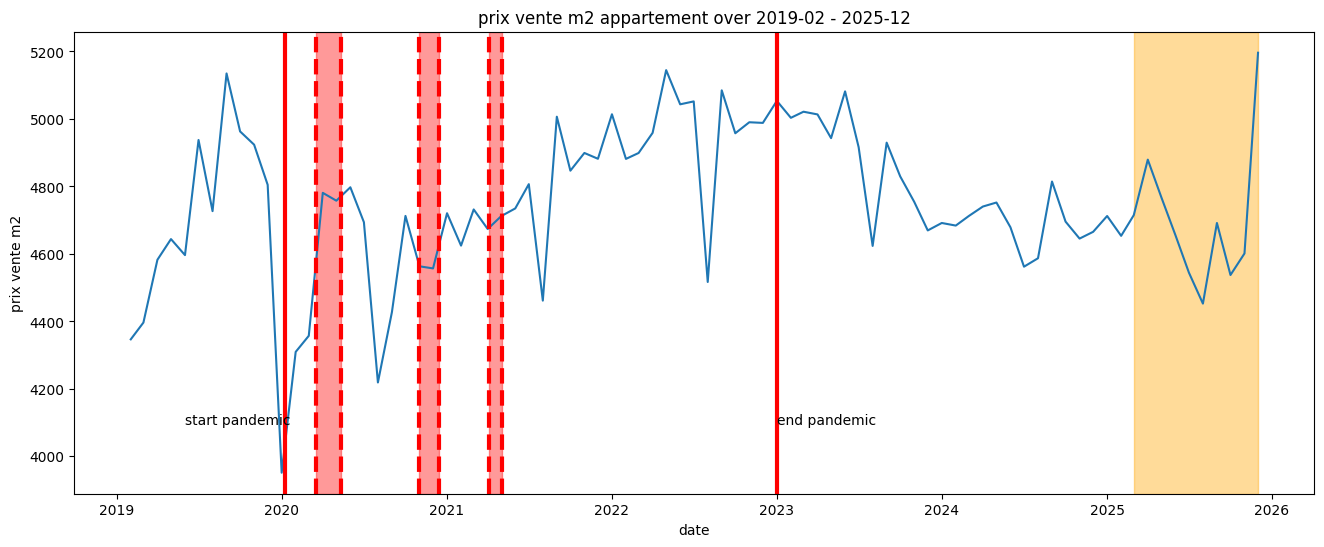

,prix_m2_vente,date
date,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000
...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000


In [44]:

df1 = df[["prix_m2_vente", "date"]]
print (df1.isna().sum())

print (df1.dtypes)
df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m")
df1 = df1.set_index('date',drop=False)
print (df1.dtypes)
df1 = df1.sort_index(ascending=True)
df2 = df1.resample("MS").mean()
df2 = df2.interpolate()

display(df2.tail(12))

plt.figure(figsize=(16,6))
title = "prix vente m2 appartement over " + df2.index[0].strftime('%Y-%m') + " - " + df2.index[0-1].strftime('%Y-%m')
plt.title (title)
plt.ylabel('prix vente m2')
plt.xlabel('date')
plt.plot(df2.prix_m2_vente)

display_pandemic()

display_extra_data()

plt.show()
display (df2)

## recover inflation rate,  loan rate ...

,date,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
0,2019-02-01,1.3,0.75,-0.4,1.5
1,2019-03-01,1.1,0.75,-0.4,1.5
2,2019-04-01,1.3,0.75,-0.4,1.5
3,2019-05-01,0.9,0.75,-0.4,1.5
4,2019-06-01,1.2,0.75,-0.4,1.5
...,...,...,...,...,...
78,2025-08-01,0.9,1.70,3.0,3.2
79,2025-09-01,1.2,1.70,3.0,3.2
80,2025-10-01,0.9,1.70,3.0,3.2
81,2025-11-01,0.9,1.70,3.0,3.2


date
2019-02-01    2.000649
2019-03-01    2.252385
2019-04-01    3.194404
2019-05-01    3.504628
2019-06-01    3.264117
                ...   
2025-08-01    2.536773
2025-09-01    3.746197
2025-10-01    2.965746
2025-11-01    3.288943
2025-12-01    6.300000
Freq: MS, Name: prix_m2_vente, Length: 83, dtype: float64


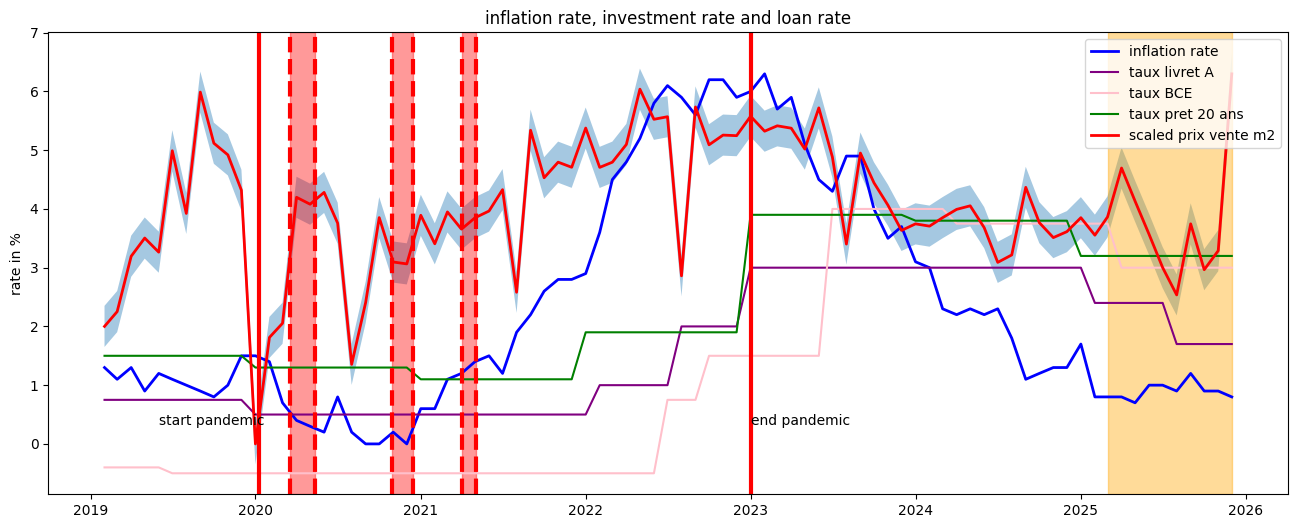

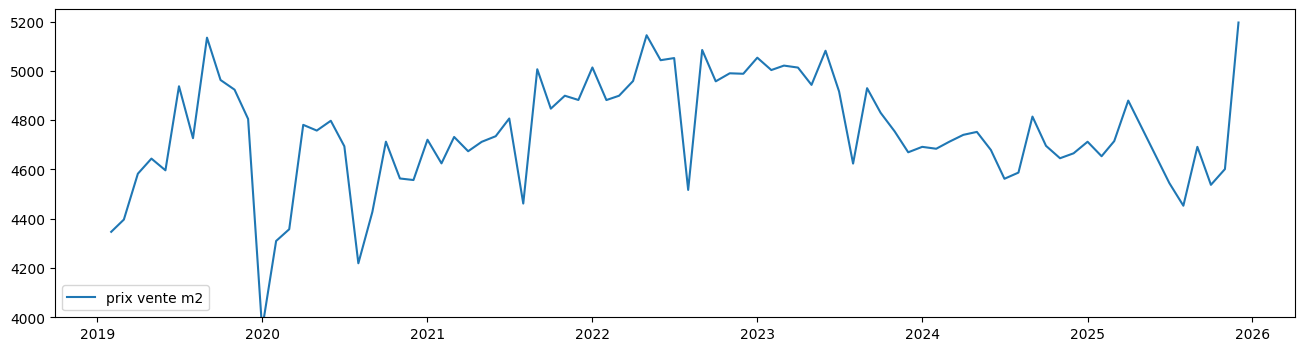

In [52]:

length = 18

start_path = Path(immo_vis_dir)
final_path = start_path / "inflation.csv"
inflation = pd.read_csv(final_path.as_posix())
inflation["date"] = pd.to_datetime(inflation["date"],format="%Y-%m")
display(inflation)

prix_scaled = (df2.prix_m2_vente -df2.prix_m2_vente.min()) / (df2.prix_m2_vente.max()-df2.prix_m2_vente.min())
prix_scaled = prix_scaled*inflation.inflation.max()
print (prix_scaled)


plt.figure(figsize=(16,6))
plt.plot (inflation.date, inflation.inflation,label="inflation rate",linewidth=2,color="blue")
plt.plot (inflation.date, inflation.taux_livret_A,label="taux livret A",color="purple")
plt.plot (inflation.date, inflation.taux_BCE,label="taux BCE",color="pink")
plt.plot (inflation.date, inflation.taux_pret_20ans,label="taux pret 20 ans",color="green")
plt.plot (inflation.date, prix_scaled,label="scaled prix vente m2",linewidth=2,color="red")
plt.title ("inflation rate, investment rate and loan rate")
plt.ylabel("rate in %")

plt.fill_between(inflation.date,prix_scaled -0.35, prix_scaled+0.35, facecolor='C0', alpha=0.4)

display_pandemic()

display_extra_data()
plt.legend()
plt.show()

from scipy.interpolate import  make_interp_spline
mean_price = df2.prix_m2_vente.mean()
xs =np.arange(len(df2.prix_m2_vente))
ys=df2.prix_m2_vente.to_numpy()

cs=make_interp_spline(xs,ys,k=3)

plt.figure(figsize=(16,4))
plt.plot (df2.date,df2.prix_m2_vente,label="prix vente m2")
# plt.plot (df2.date,mean_price+ cs(xs,1), label="smoothed prix vente m2")
plt.ylim((4000,5250))

plt.legend()








## Prophet Predictions

,y,ds
date,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000
...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000


08:51:02 - cmdstanpy - INFO - Chain [1] start processing
08:51:02 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2019-02-01
1,2019-03-01
2,2019-04-01
3,2019-05-01
4,2019-06-01
...,...
78,2025-08-01
79,2025-09-01
80,2025-10-01
81,2025-11-01


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-01,4551.776571,4260.011513,4640.549430,4551.776571,4551.776571,-92.912003,-92.912003,-92.912003,-92.912003,-92.912003,-92.912003,0.0,0.0,0.0,4458.864568
1,2019-03-01,4556.972019,4430.368579,4808.506827,4556.972019,4556.972019,65.537223,65.537223,65.537223,65.537223,65.537223,65.537223,0.0,0.0,0.0,4622.509242
2,2019-04-01,4562.724121,4449.981663,4823.922058,4562.724121,4562.724121,75.216400,75.216400,75.216400,75.216400,75.216400,75.216400,0.0,0.0,0.0,4637.940522
3,2019-05-01,4568.290672,4460.694416,4852.745425,4568.290672,4568.290672,76.030638,76.030638,76.030638,76.030638,76.030638,76.030638,0.0,0.0,0.0,4644.321311
4,2019-06-01,4574.042775,4430.192188,4810.185663,4574.042775,4574.042775,47.386973,47.386973,47.386973,47.386973,47.386973,47.386973,0.0,0.0,0.0,4621.429748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2025-08-01,4548.260377,4109.236481,4489.682644,4517.197536,4583.911968,-250.981709,-250.981709,-250.981709,-250.981709,-250.981709,-250.981709,0.0,0.0,0.0,4297.278669
79,2025-09-01,4535.711631,4464.472310,4858.644218,4501.511856,4575.272194,126.337552,126.337552,126.337552,126.337552,126.337552,126.337552,0.0,0.0,0.0,4662.049183
80,2025-10-01,4523.567682,4467.032743,4863.479549,4486.136655,4566.579101,129.439031,129.439031,129.439031,129.439031,129.439031,129.439031,0.0,0.0,0.0,4653.006713
81,2025-11-01,4511.018935,4355.079697,4749.470955,4470.777889,4558.494664,41.976862,41.976862,41.976862,41.976862,41.976862,41.976862,0.0,0.0,0.0,4552.995797


array([4562.13855033, 4587.19206505, 4814.49354062, 4695.73440254,
       4645.44919171, 4665.43375163, 4712.36444748, 4653.59862172,
       4714.9438239 , 4879.40961472, 4767.79750654, 4656.18539837,
       4544.5732902 , 4452.7515553 , 4691.69850858, 4537.50411592,
       4601.3584659 , 5196.25578399])

array([4925.83973112, 4430.45594015, 4760.49258526, 4829.40766379,
       4671.14042467, 4585.16525921, 4777.38322671, 4538.95262647,
       4526.07489939, 4650.24597945, 4681.7997084 , 4672.5180406 ,
       4733.70215807, 4297.27866873, 4662.04918284, 4653.00671346,
       4552.99579739, 4481.98109988])


=== Model Performance ===
MAE: 153.69
RMSE: 221.69
R² Score: -0.9429


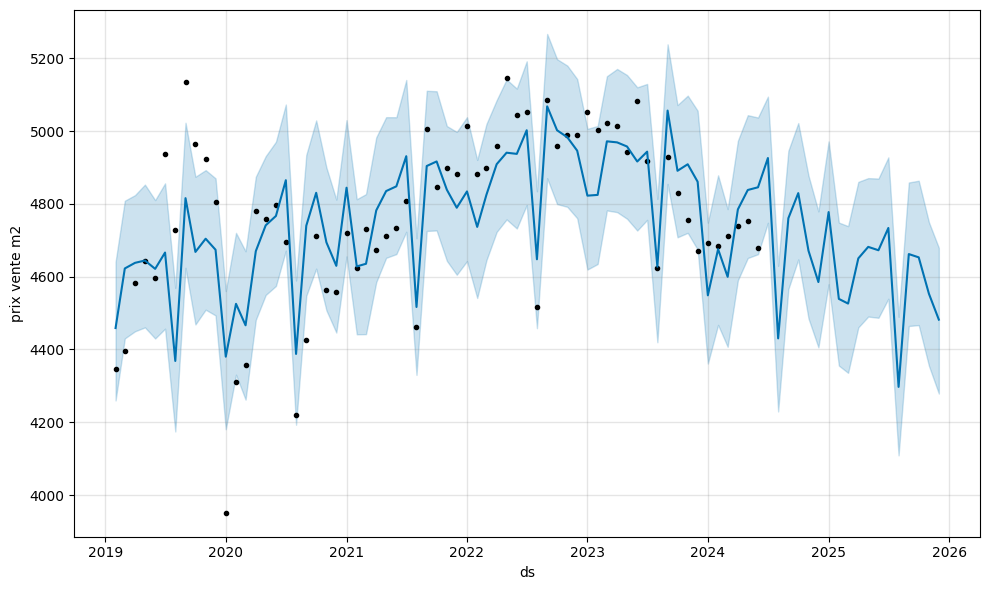

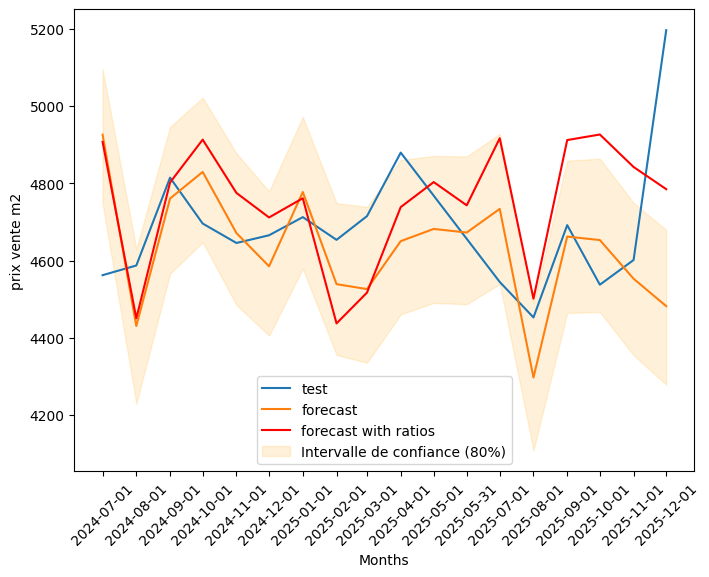

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
length = 18
df3 = df2.rename(columns={"date" : "ds","prix_m2_vente":"y"})
display(df3)

train_data = df3[:-length]
test_data = df3[-length:]

model = Prophet (changepoint_prior_scale=0.05)
model.fit (train_data)

future = model.make_future_dataframe(periods=length,freq="MS")
display(future)

forecast = model.predict(future)
display(forecast)

model.plot(forecast, ylabel = "prix vente m2")

y_true = test_data['y'].values
y_pred = forecast['yhat'][-length:].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n=== Model Performance ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

plt.show()

plt.figure(figsize=(8, 6))
plt.plot(test_data['ds'],test_data["y"],label="test")
plt.plot(test_data['ds'],forecast["yhat"].iloc[-length:],label="forecast")

plt.ylabel('prix vente m2')
plt.xlabel('Months')
plt.xticks(test_data['ds'], rotation=45)

plt.fill_between(test_data['ds'], forecast['yhat_lower'].tail(length), forecast['yhat_upper'].tail(length), 
                 color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.legend()
plt.show()

,y,ds,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
date,,,,,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000,1.1,0.75,-0.4,1.5
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000,0.9,0.75,-0.4,1.5
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000,1.2,0.75,-0.4,1.5
...,...,...,...,...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000,0.9,1.70,3.0,3.2
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000,1.2,1.70,3.0,3.2
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000,0.9,1.70,3.0,3.2


09:11:43 - cmdstanpy - INFO - Chain [1] start processing
09:11:43 - cmdstanpy - INFO - Chain [1] done processing


Index(['y', 'ds', 'inflation', 'taux_livret_A', 'taux_BCE', 'taux_pret_20ans'], dtype='object')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,taux_pret_20ans,taux_pret_20ans_lower,taux_pret_20ans_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-01 00:00:00.000000000,4919.139326,4744.473491,5096.026404,4919.137978,4919.140600,-11.970058,-11.970058,-11.970058,-179.546847,...,201.396961,201.396961,201.396961,167.576790,167.576790,167.576790,0.0,0.0,0.0,4907.169269
1,2024-08-01 00:00:00.000000000,4923.976467,4278.149201,4607.485101,4923.971767,4923.980718,-473.539805,-473.539805,-473.539805,-200.399629,...,201.396961,201.396961,201.396961,-273.140176,-273.140176,-273.140176,0.0,0.0,0.0,4450.436662
2,2024-09-01 00:00:00.000000000,4928.813608,4633.764286,4984.724931,4928.804171,4928.822496,-126.759119,-126.759119,-126.759119,-229.593523,...,201.396961,201.396961,201.396961,102.834404,102.834404,102.834404,0.0,0.0,0.0,4802.054489
3,2024-10-01 00:00:00.000000000,4933.494712,4734.620233,5089.358669,4933.480383,4933.510622,-20.567222,-20.567222,-20.567222,-225.422967,...,201.396961,201.396961,201.396961,204.855745,204.855745,204.855745,0.0,0.0,0.0,4912.927490
4,2024-11-01 00:00:00.000000000,4938.331853,4594.725185,4935.028321,4938.309873,4938.354625,-163.324546,-163.324546,-163.324546,-221.252411,...,201.396961,201.396961,201.396961,57.927865,57.927865,57.927865,0.0,0.0,0.0,4775.007308
5,2024-12-01 00:00:00.000000000,4943.012957,4538.964975,4877.332979,4942.982159,4943.043090,-231.498194,-231.498194,-231.498194,-221.252411,...,201.396961,201.396961,201.396961,-10.245783,-10.245783,-10.245783,0.0,0.0,0.0,4711.514764
6,2024-12-31 23:59:59.999999744,4947.850098,4593.423743,4939.310329,4947.810105,4947.889239,-186.655382,-186.655382,-186.655382,-276.431864,...,129.535282,129.535282,129.535282,89.776482,89.776482,89.776482,0.0,0.0,0.0,4761.194717
7,2025-02-01 00:00:00.000000000,4952.687239,4260.652778,4604.349828,4952.636926,4952.737989,-515.408822,-515.408822,-515.408822,-320.679642,...,129.535282,129.535282,129.535282,-194.729180,-194.729180,-194.729180,0.0,0.0,0.0,4437.278417
8,2025-03-01 00:00:00.000000000,4957.056270,4337.119150,4690.171416,4956.996341,4957.116923,-440.113716,-440.113716,-440.113716,-320.679642,...,129.535282,129.535282,129.535282,-119.434074,-119.434074,-119.434074,0.0,0.0,0.0,4516.942553
9,2025-04-01 00:00:00.000000000,4961.893411,4557.600181,4917.177239,4961.820954,4961.962654,-223.561281,-223.561281,-223.561281,-227.678172,...,129.535282,129.535282,129.535282,4.116891,4.116891,4.116891,0.0,0.0,0.0,4738.332130



=== Model Performance with inflation rate, investment rate and loan rate ===
MAE: 183.05
RMSE: 222.19
R² Score: -0.9516


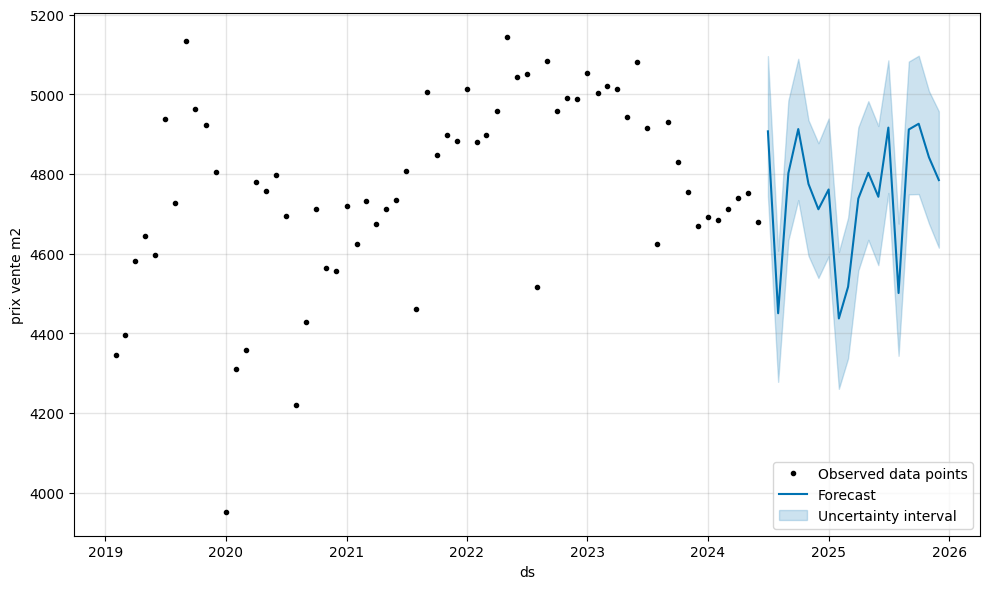

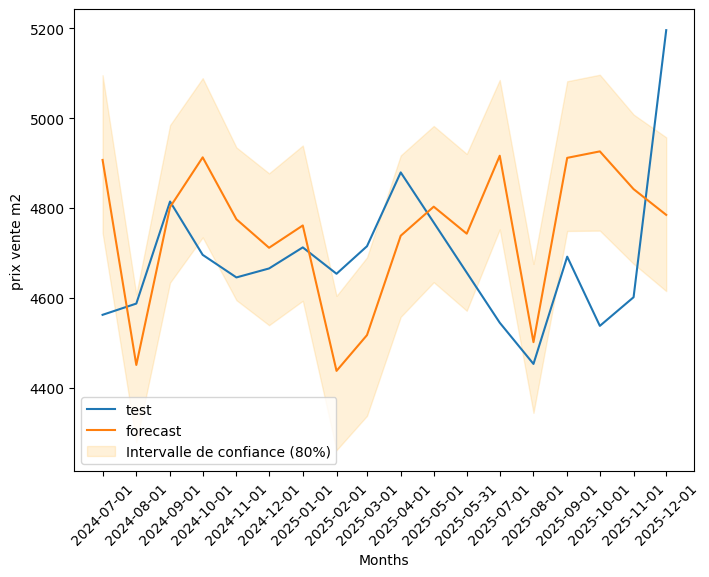

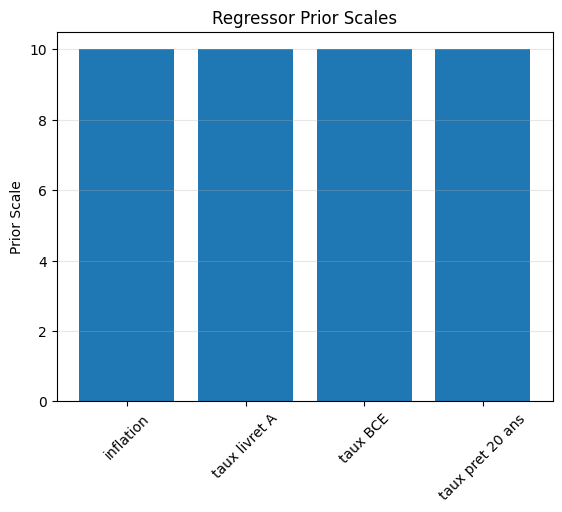

In [29]:
from prophet import Prophet
length = 18

df3 = df2.rename(columns={"date" : "ds","prix_m2_vente":"y"})
df3 = pd.merge(df3,inflation,left_index=True,right_on="date")
df3.set_index(df2.index,inplace=True)
df3.drop("date",axis=1,inplace=True)

display(df3)
print (df3.columns)

df_train = df3[:-length]
df_test = df3[-length:]


model = Prophet (yearly_seasonality=True,changepoint_prior_scale=0.05)

model.add_regressor('inflation')
model.add_regressor('taux_livret_A')
model.add_regressor('taux_BCE')
model.add_regressor('taux_pret_20ans')

attributes = ['ds', 'y', 'inflation','taux_livret_A','taux_BCE','taux_pret_20ans']
local_frame = df_train[attributes]
model.fit (local_frame)

future = model.make_future_dataframe(periods=length,freq="MS")
future = df_test[attributes].copy()

forecast = model.predict(future)
display(forecast)

y_true = test_data['y'].values
y_pred = forecast['yhat'][-length:].values

mae_rates = mean_absolute_error(y_true, y_pred)
rmse_rates = np.sqrt(mean_squared_error(y_true, y_pred))
r2_rates = r2_score(y_true, y_pred)

print("\n=== Model Performance with inflation rate, investment rate and loan rate ===")
print(f"MAE: {mae_rates:.2f}")
print(f"RMSE: {rmse_rates:.2f}")
print(f"R² Score: {r2_rates:.4f}")


model.plot(forecast, ylabel = "prix vente m2",plot_cap=True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_test['ds'],df_test["y"],label="test")
plt.plot(df_test['ds'],forecast["yhat"].iloc[-length:],label="forecast")
plt.ylabel('prix vente m2')
plt.xlabel('Months')
plt.xticks(df_test['ds'], rotation=45)

plt.fill_between(df_test['ds'], forecast['yhat_lower'].tail(length), forecast['yhat_upper'].tail(length), 
                 color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.legend()
plt.show()

forecast1 = forecast

regressor_coefficients = {
    'inflation': model.extra_regressors['inflation']['prior_scale'],
    'taux livret A': model.extra_regressors['taux_livret_A']['prior_scale'],
    'taux BCE': model.extra_regressors['taux_BCE']['prior_scale'],
    'taux pret 20 ans': model.extra_regressors['taux_pret_20ans']['prior_scale']
}
plt.bar(regressor_coefficients.keys(), regressor_coefficients.values())
plt.ylabel('Prior Scale')
plt.title('Regressor Prior Scales')
plt.tick_params(axis='x', rotation=45)
plt.grid(True, alpha=0.3, axis='y')


# Prophet analysis summary


=== Model Performance ===
MAE: 153.69
RMSE: 221.69
R² Score: -0.9429

=== Model Performance with inflation rate, investment rate and loan rate ===
MAE: 183.05
RMSE: 222.19
R² Score: -0.9516


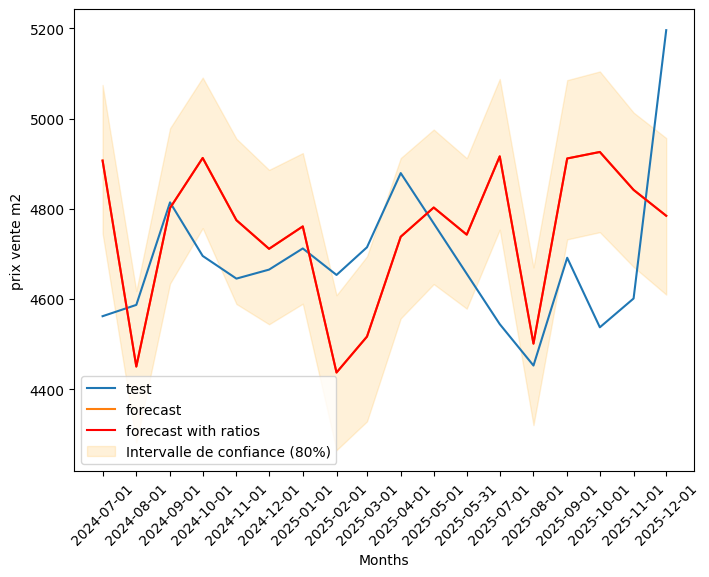

In [26]:

print("\n=== Model Performance ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


print("\n=== Model Performance with inflation rate, investment rate and loan rate ===")
print(f"MAE: {mae_rates:.2f}")
print(f"RMSE: {rmse_rates:.2f}")
print(f"R² Score: {r2_rates:.4f}")



plt.figure(figsize=(8, 6))
plt.plot(test_data['ds'],test_data["y"],label="test")
plt.plot(test_data['ds'],forecast["yhat"].iloc[-length:],label="forecast")
plt.plot(test_data['ds'],forecast1["yhat"].iloc[-length:],label="forecast with ratios",color="red")

plt.ylabel('prix vente m2')
plt.xlabel('Months')
plt.xticks(test_data['ds'], rotation=45)

plt.fill_between(test_data['ds'], forecast['yhat_lower'].tail(length), forecast['yhat_upper'].tail(length), 
                 color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.legend()
plt.show()